In [ ]:
%cd /content/drive/My Drive/COVID_APP

/content/drive/My Drive/COVID_APP


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
import copy
from torch.utils.data import random_split
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_dir = '/content/drive/My Drive/COVID_APP/train'
test_dir = '/content/drive/My Drive/COVID_APP/test'

In [ ]:
stats = ((0.4853, 0.4853, 0.4855) ,(0.2182, 0.2182, 0.2183))

trainset = transforms.Compose([transforms.Resize((256, 256)),
                               transforms.ToTensor(),
                               transforms.Normalize(*stats, inplace=True)])

testset = transforms.Compose([transforms.Resize((256, 256)),
                               transforms.ToTensor(),
                               transforms.Normalize(*stats)])

In [ ]:
dataset = ImageFolder(train_dir, transform=trainset)
test_data = ImageFolder(test_dir, transform=testset)

In [ ]:
valid_set_perc = 0.1
val_size = int(valid_set_perc*len(dataset))
train_size = len(dataset)-val_size
train_data, valid_data = random_split(dataset, [train_size, val_size])

In [ ]:
batchsize = 64
train_dl = DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=2, pin_memory=True)

valid_dl = DataLoader(valid_data, batch_size = batchsize*2, num_workers=2, pin_memory=True)

test_dl = DataLoader(test_data, batch_size=batchsize, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid 

# UTILS FUNCTION

def show_batch(dl, invert=False):
  for images, labels in dl:
      fig, ax = plt.subplots(figsize=(16, 8))
      ax.set_xticks([]); ax.set_yticks([])
      data = 1-images if invert else images
      ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
      break    

def show_images(img, label):
  print("label:"+ dataset.classes[label]+" "+ str(label))
  plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:NORMAL 1


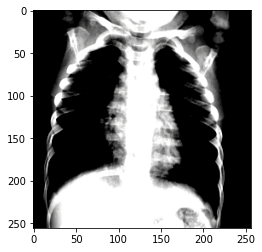

In [ ]:
show_images(*dataset[1500])

In [ ]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class devicedataloader():
  def __init__(self, dl, device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

device = get_device()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


trn_dl =devicedataloader(train_dl, device)
val_dl = devicedataloader(valid_dl, device)
tst_dl = devicedataloader(test_dl, device)

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out=self(images)
    loss = F.cross_entropy(out, labels)
    accu = accuracy(out, labels)
    return {"val_loss": loss.detach(), "val_accuracy": accu}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    batch_accuracy = [x["val_accuracy"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))



In [ ]:
class ChestCnnModel1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            
        )
        
    def forward(self, xb):
        return self.network(xb)


In [ ]:
model = to_device(ChestCnnModel1(), device)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[1]:', out[1])
        print(labels.shape)
        
        break

try_batch(trn_dl)

images.shape: torch.Size([64, 3, 256, 256])
out.shape: torch.Size([64, 3])
out[1]: tensor([0.0800, 0.0481, 0.0332], device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([64])


In [ ]:

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [ ]:
%%time
history = [evaluate(model, val_dl)]
history

ModuleAttributeError: ignored

In [ ]:
epochs = 20
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, trn_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay= weight_decay, 
                             opt_func=opt_func)

NameError: ignored

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

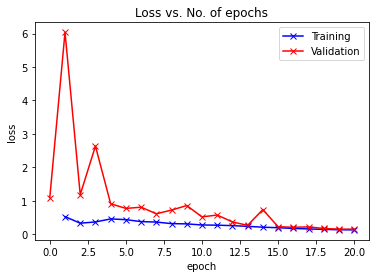

In [ ]:
plot_losses(history)

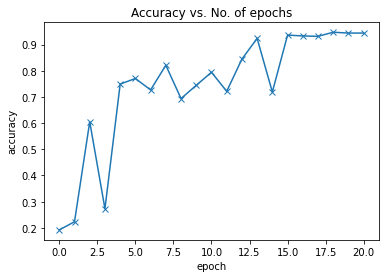

In [ ]:
plot_accuracies(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]




evaluate(model, tst_dl)

{'val_accuracy': tensor(0.9487), 'val_loss': tensor(0.1526, device='cuda:0')}

In [ ]:
test_data.classes

['COVID19', 'NORMAL', 'PNEUMONIA']

In [ ]:
torch.save(model, "normal_save.pth")

In [ ]:
torch.save(model.state_dict(), "dicts_save.pth")

In [ ]:
optimizer

NameError: ignored

In [ ]:
model = to_device(ChestCnnModel1(), device)

In [ ]:
model.load_state_dict(torch.load("dicts_save.pth", map_location=torch.device('cpu')))
model.eval()

ChestCnnModel1(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

@app.route('/predict', methods=['POST'])
def predict():
    return jsonify({'class_id': 'IMAGE_NET_XXX', 'class_name': 'Cat'})

if __name__ == '__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://42c9275fd574.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [09/Nov/2020 11:36:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Nov/2020 11:36:35] "GET /favicon.ico HTTP/1.1" 404 -
